# 네이버 영화 리뷰 감성 분석 도전하기 프로젝트

## 모듈 불러오기

In [1]:
import pandas as pd
import tensorflow as tf
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models import KeyedVectors
from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


## 데이터 읽어오기

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석과 가공

In [7]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 모델 구성

하이퍼파라메터

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

### LSTM

In [11]:
# model 설계
model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_LSTM.add(tf.keras.layers.Dense(8, activation='relu'))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3712      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 413,857
Trainable params: 413,857
Non-trainable params: 0
_________________________________________________________________


### CNN

In [12]:
model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### GlobalMaxPooling1D

In [13]:
model_GMP = tf.keras.Sequential()
model_GMP.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GMP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 41)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 336       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


### validation set 만들기

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

## 모델 훈련

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

epochs=20

### LSTM

In [16]:
model_LSTM.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_LSTM = model_LSTM.fit(X_train,
                              y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping],
                              verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.4537 - accuracy: 0.7905 - val_loss: 0.3605 - val_accuracy: 0.8431
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3305 - accuracy: 0.8601 - val_loss: 0.3560 - val_accuracy: 0.8440
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3082 - accuracy: 0.8706 - val_loss: 0.3499 - val_accuracy: 0.8491
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2910 - accuracy: 0.8797 - val_loss: 0.3469 - val_accuracy: 0.8507
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2750 - accuracy: 0.8872 - val_loss: 0.3509 - val_accuracy: 0.8512
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2583 - accuracy: 0.8955 - val_loss: 0.3597 - val_accuracy: 0.8507
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2429 - accuracy: 0.9022 - val_loss: 0.3678 - val_accuracy: 0.8478
Epoch 

### CNN

In [17]:
model_CNN.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_CNN = model_CNN.fit(X_train,
                            y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 6ms/step - loss: 0.4708 - accuracy: 0.7779 - val_loss: 0.3561 - val_accuracy: 0.8451
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3176 - accuracy: 0.8647 - val_loss: 0.3421 - val_accuracy: 0.8513
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2770 - accuracy: 0.8861 - val_loss: 0.3401 - val_accuracy: 0.8551
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2361 - accuracy: 0.9070 - val_loss: 0.3538 - val_accuracy: 0.8522
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1889 - accuracy: 0.9302 - val_loss: 0.3864 - val_accuracy: 0.8456
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1420 - accuracy: 0.9513 - val_loss: 0.4347 - val_accuracy: 0.8432
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1048 - accuracy: 0.9655 - val_loss: 0.4912 - val_accuracy: 0.8374
Epoch 

### GlobalMaxPooling1D

In [18]:
model_GMP.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_GMP = model_GMP.fit(X_train,
                            y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.5471 - accuracy: 0.7361 - val_loss: 0.3913 - val_accuracy: 0.8297
Epoch 2/20
229/229 [==============================] - 1s 3ms/step - loss: 0.3452 - accuracy: 0.8516 - val_loss: 0.3539 - val_accuracy: 0.8447
Epoch 3/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2986 - accuracy: 0.8750 - val_loss: 0.3501 - val_accuracy: 0.8471
Epoch 4/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2686 - accuracy: 0.8900 - val_loss: 0.3563 - val_accuracy: 0.8465
Epoch 5/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2438 - accuracy: 0.9021 - val_loss: 0.3662 - val_accuracy: 0.8457
Epoch 6/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2216 - accuracy: 0.9127 - val_loss: 0.3802 - val_accuracy: 0.8445
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2012 - accuracy: 0.9228 - val_loss: 0.3967 - val_accuracy: 0.8424
Epoch 

In [19]:
results_LSTM= model_LSTM.evaluate(X_test,  y_test, verbose=2)
results_CNN= model_CNN.evaluate(X_test,  y_test, verbose=2)
results_GMP= model_GMP.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.5044 - accuracy: 0.8400
1537/1537 - 3s - loss: 0.8547 - accuracy: 0.8223
1537/1537 - 2s - loss: 0.5457 - accuracy: 0.8285


## Loss, Accuracy 그래프 시각화

In [20]:
history_LSTM_dict = history_LSTM.history
history_CNN_dict = history_CNN.history
history_GMP_dict = history_GMP.history

### LSTM

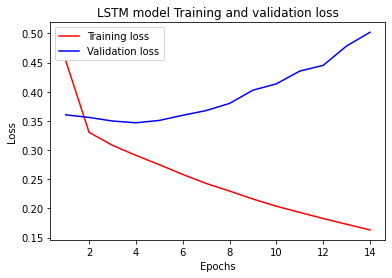

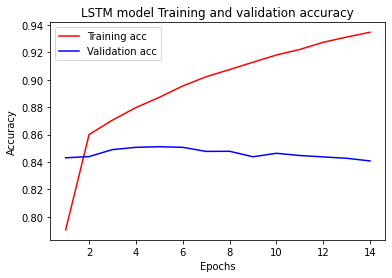

In [21]:
acc = history_LSTM_dict['accuracy']
val_acc = history_LSTM_dict['val_accuracy']
loss = history_LSTM_dict['loss']
val_loss = history_LSTM_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM model Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM model Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN

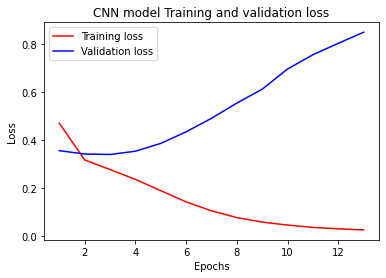

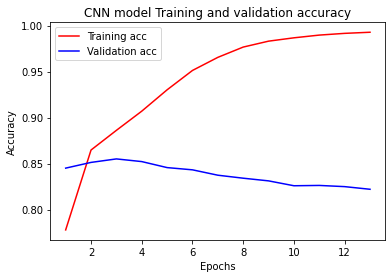

In [22]:
acc = history_CNN_dict['accuracy']
val_acc = history_CNN_dict['val_accuracy']
loss = history_CNN_dict['loss']
val_loss = history_CNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN model Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN model Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D

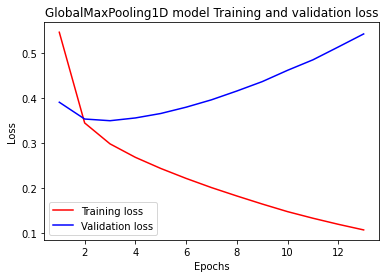

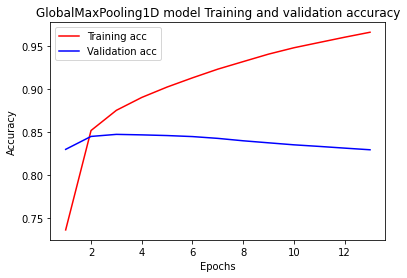

In [23]:
acc = history_GMP_dict['accuracy']
val_acc = history_GMP_dict['val_accuracy']
loss = history_GMP_dict['loss']
val_loss = history_GMP_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling1D model Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling1D model Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding layer 분석

### LSTM

In [24]:
embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [25]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_L.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [27]:
vector = word_vectors['만족']

In [28]:
vector

array([-0.13367875, -0.04139495, -0.13510539,  0.02776962,  0.02958685,
       -0.11695593, -0.00385209,  0.07329651,  0.04752306, -0.00355844,
       -0.07286004, -0.0530297 , -0.03841142,  0.10305776, -0.02477401,
        0.04463208,  0.1438937 , -0.02264426,  0.13845952, -0.1153179 ,
        0.08768571,  0.08703138, -0.0673189 , -0.05560126, -0.04570829,
       -0.01634182,  0.0582044 , -0.01185945, -0.0241849 , -0.05382815,
       -0.00539506, -0.14445665,  0.16043381,  0.12245699,  0.06408056,
       -0.01955932, -0.08483909,  0.0572652 ,  0.09389755, -0.07952701,
        0.07901199], dtype=float32)

In [29]:
word_vectors.similar_by_word("실망")

[('재미없', 0.9549404978752136),
 ('뻔했', 0.9504951238632202),
 ('왜곡', 0.9472715854644775),
 ('억지', 0.9423035979270935),
 ('식상', 0.9413183927536011),
 ('건만', 0.9404082298278809),
 ('어설프', 0.9401983618736267),
 ('꼴', 0.9384808540344238),
 ('22', 0.9380655288696289),
 ('일방', 0.9367996454238892)]

### CNN

In [30]:
embedding_layer = model_CNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [31]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_C.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_CNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [33]:
vector = word_vectors['만족']
vector

array([ 0.03359465, -0.06119943, -0.0584445 ,  0.01862429,  0.20294802,
        0.04783661, -0.18208675, -0.10910131,  0.01224909,  0.17081371,
        0.09962538,  0.15279342, -0.16878287, -0.0452942 , -0.05371694,
       -0.17450334, -0.1017643 , -0.07569425,  0.09138951, -0.13677399,
       -0.03044802,  0.04477146, -0.02359182,  0.07880712,  0.02340422,
       -0.14443442,  0.0628894 ,  0.08564871, -0.07327683,  0.05854724,
        0.1345835 , -0.24441428,  0.05764474, -0.0975018 ,  0.16350792,
       -0.00279534, -0.17176127,  0.09971622,  0.11889676,  0.12871121,
        0.15356863], dtype=float32)

In [34]:
word_vectors.similar_by_word("실망")

[('쓰레', 0.8283827304840088),
 ('을껄', 0.8275079131126404),
 ('역겨웠', 0.8132032752037048),
 ('그다지', 0.8131734728813171),
 ('협박', 0.8068961501121521),
 ('뻥튀기', 0.8067506551742554),
 ('콩가루', 0.8051186203956604),
 ('줄리아로버츠', 0.805000901222229),
 ('사도', 0.8042213916778564),
 ('거북', 0.8008834719657898)]

### GlobalMaxPooling1D

In [35]:
embedding_layer = model_GMP.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [36]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_G.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_GMP.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [38]:
vector = word_vectors['만족']
vector

array([-0.05371884,  0.06630457, -0.10263552, -0.08251883, -0.04354342,
        0.0375594 , -0.00521649, -0.16827232, -0.00081135, -0.10451351,
        0.16887288, -0.08985195, -0.11474197, -0.1179129 ,  0.00145721,
       -0.14863105, -0.10219771,  0.16862895, -0.01438947, -0.00818843,
       -0.11938372, -0.12306859, -0.03083792,  0.05597275, -0.11500738,
        0.05927687, -0.09237466, -0.01026276, -0.02110372, -0.00312618,
       -0.13947852,  0.16279742,  0.0366486 , -0.15017664,  0.01791321,
       -0.00055329, -0.03802097, -0.10630622,  0.06554256,  0.02787033,
       -0.11305562], dtype=float32)

In [39]:
word_vectors.similar_by_word("실망")

[('누르', 0.7496523261070251),
 ('총싸움', 0.723591148853302),
 ('막혀', 0.722227156162262),
 ('--;', 0.702759861946106),
 ('0', 0.6925692558288574),
 ('킥', 0.6874768733978271),
 ('억지', 0.6837041974067688),
 ('맺', 0.677971601486206),
 ('력', 0.6766816973686218),
 ('과한', 0.669981062412262)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [40]:
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [41]:
vector = word2vec['안녕']
vector

/tmp/ipykernel_894/1301817003.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['안녕']


array([-4.48758937e-02, -5.26038110e-01,  2.18058324e+00, -2.70098805e-01,
       -1.22612631e+00, -4.35174644e-01,  8.78038049e-01,  1.78903091e+00,
        5.13344407e-01,  8.00866067e-01,  1.33781850e-01,  4.23676372e-01,
        6.25718057e-01, -1.49838462e-01, -2.65716583e-01, -1.18363452e+00,
        1.09828494e-01,  6.56335890e-01,  9.90437388e-01, -2.88908720e-01,
       -4.82253104e-01, -1.71825096e-01, -5.22048175e-01, -1.37081638e-01,
        4.01715070e-01, -3.54384005e-01, -4.38563734e-01,  3.37939188e-02,
       -4.21380460e-01, -2.11324722e-01,  5.34786046e-01,  5.26668072e-01,
       -3.78847629e-01, -1.59311071e-01,  1.77993524e+00, -1.28354877e-01,
        4.53990996e-01,  6.38647795e-01,  3.22042465e-01, -6.49676397e-02,
       -9.30086493e-01,  6.84082747e-01, -1.41875729e-01, -1.49376774e+00,
        1.44657120e-03,  4.33810472e-01, -7.31874406e-02,  7.40463585e-02,
       -6.44519210e-01,  1.11461449e+00, -8.20367783e-02, -5.76601565e-01,
        1.71026981e+00,  

In [42]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_894/4247654489.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_894/4247654489.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [43]:
# 모델 구성
model_w = keras.Sequential()
model_w.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_w.add(keras.layers.LSTM(512))
model_w.add(keras.layers.Dense(8, activation='relu'))
model_w.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_w.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_w.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_w = model_w.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 16s 63ms/step - loss: 0.4497 - accuracy: 0.7835 - val_loss: 0.3600 - val_accuracy: 0.8401
Epoch 2/20
229/229 [==============================] - 14s 62ms/step - loss: 0.3179 - accuracy: 0.8623 - val_loss: 0.3223 - val_accuracy: 0.8603
Epoch 3/20
229/229 [==============================] - 14s 63ms/step - loss: 0.2707 - accuracy: 0.8866 - val_loss: 0.3197 - val_accuracy: 0.8598
Epoch 4/20
229/229 [==============================] - 15s 64ms/step - loss: 0.2330 - accuracy: 0.9055 - val_loss: 0.3194 - val_accuracy: 0.8680
Epoch 5/20
229/229 [==============================] - 15s 64ms/step - loss: 0.1924 - accuracy: 0.9234 - val_loss: 0.3458 - val_accuracy: 0.8646
Epoch 6/20
229/229 [==============================] - 15s 65ms/step - loss: 0.1512 - accuracy: 0.9424 - val_loss: 0.3738 - val_accuracy: 0.8627
Epoch 7/20
229/229 [==============================] - 15s 65ms/step - loss: 0.1102 - accuracy: 0.9586 - val_loss: 0.4345 - val_accuracy:

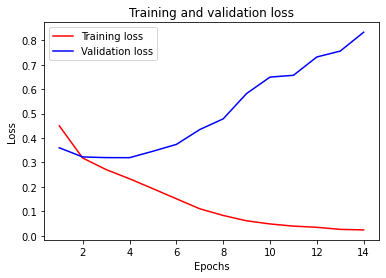

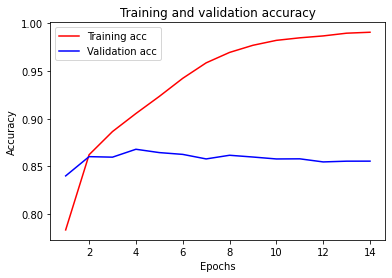

In [45]:
history_w_dict = history_w.history

acc = history_w_dict['accuracy']
val_acc = history_w_dict['val_accuracy']
loss = history_w_dict['loss']
val_loss = history_w_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---
## 회고

### 루브릭 관련 고려한 점
#### 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.    

* 여러 모델을 사용해서 성공적으로 시도했다.    

#### 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.    

* gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 분석했다.   

#### 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.   

* 네이버 영화리뷰 데이터 감성분석 정확도를, 한국어 Word2Vec을 활용해서 모델을 훈련시켰고,   
  val_accuracy: 0.8556 으로, 정확도 85% 이상을 달성했다.   
---
적절한 epoch를 찾는 방법을 찾아보다가 Early stopping 함수를 알게되었음.   
Early stopping 함수를 쓰면 validation loss가 증가하는 시점에 훈련을 멈추게 한다.   

ko.bin을 불러오는 부분에서 조금 많이 헤맸다.    
gensim을 다운그레이드하는 방법도 어떻게 하는건지 몰랐는데, 잼보드에 있는 내용을 참고해서 성공했다.   

모델의 레이어에 대한 것도 아직 이해가 잘 안되는 것 같다.   
더 찾아보고 공부해야할것같다...   

## 참고자료

* https://3months.tistory.com/424   

* https://wikidocs.net/50739   